In [1]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import numpy as np
from datetime import datetime
import xarray as xr
from xarray.backends import NetCDF4DataStore
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter

## Surface Wind Gusts

In [3]:
%%capture

VALID_TIME = '2021-03-28T2100'

# Define area to plot
BOTTOM_LAT = 23
TOP_LAT = 40
LEFT_LON = -97
RIGHT_LON = -70

# Model Endpoints 
hrrr = 'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr20210327/hrrr_sfc.t12z'
arw = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw20200430/hiresw_conusarw_12z'
nbm = 'https://nomads.ncep.noaa.gov/dods/blend/blend20200417/blend_1hr_22z'
rap = 'https://nomads.ncep.noaa.gov/dods/rap/rap20200722/rap_15z'
gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs20200429/gfs_0p25_18z'

base_url = hrrr

ds = xr.open_dataset(base_url, decode_times=True)

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)

if base_url == gfs:
    LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)
else:
    LON_SLICE = slice(LEFT_LON, RIGHT_LON)
    
# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values

if base_url == gfs:
    lons = ds.lon.sel(lon=LON_SLICE).values
else:
    lons = 360 + ds.lon.sel(lon=LON_SLICE).values


gust = ds.gustsfc.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE, 
                                  time=VALID_TIME).squeeze().metpy.unit_array * units('m/s')
gust = gust.to('mph')

def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

LOCAL_TIME = convert_datetime_from_nomads_to_local(VALID_TIME)

## Setup Basemap and Plot Data

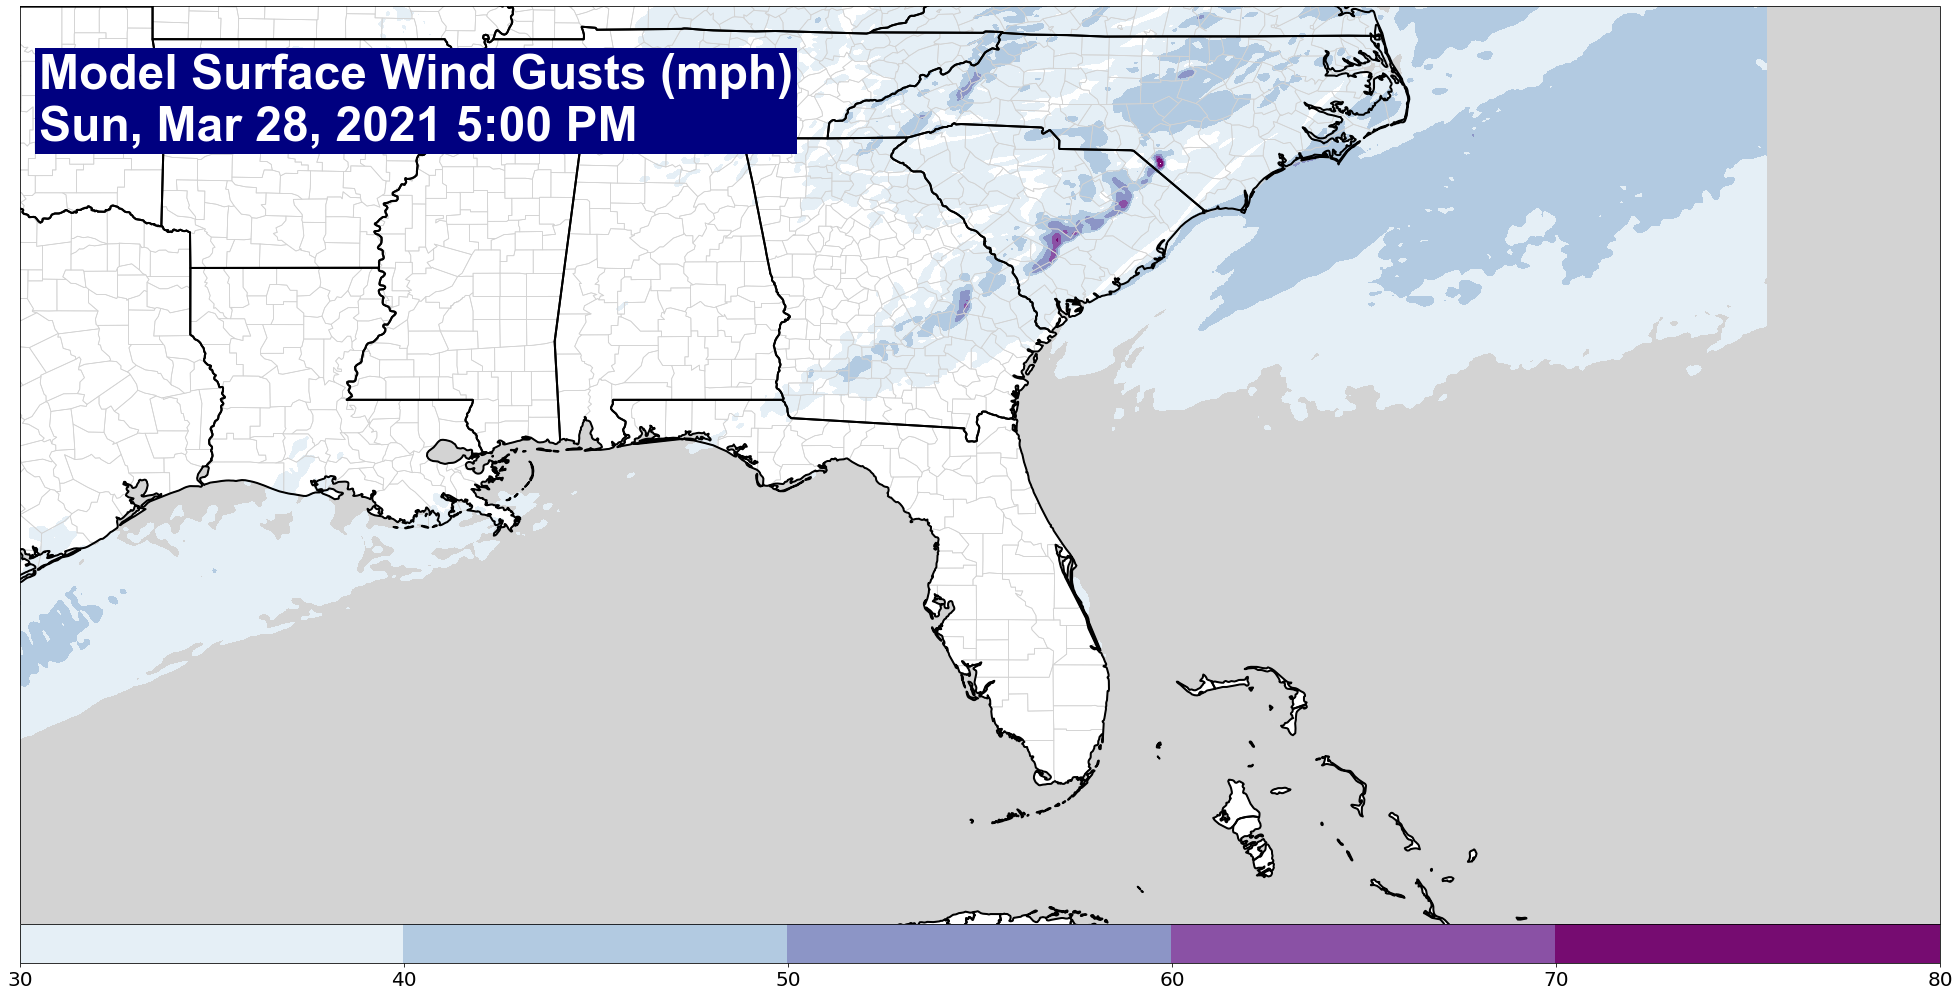

In [4]:
# Setup matplotlib figure
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', zorder=1, linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.00)
ax.set_extent([-89, -75, 23, 37])
ax.set_adjustable('datalim')

# Plot isotachs
gust_values = np.arange(30, 90, 10)
contour_fill = ax.contourf(lons, lats, gust, gust_values,
                      cmap=plt.cm.BuPu, transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour_fill, orientation='horizontal', pad=0, aspect=50)
cbar.ax.tick_params(labelsize=20)

# Display Banner
plt.text(0.01, 0.95, s=f'Model Surface Wind Gusts (mph)\n{LOCAL_TIME}',
         fontname='Arial', fontsize=48, fontweight='bold', color='white',
         bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
         transform=ax.transAxes, zorder=10, va='top')

# Save figure
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'
plt.savefig(f'{graphics_dir}/gust_{VALID_TIME}.png', dpi=72)
plt.show()